# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

Заказчику необходимы ответы на следующие вопросы:
1. Есть ли зависимость между наличием детей и возвратом кредита в срок?
2. Есть ли зависимость между семейным положением и возвратом кредита в срок?
3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
4. Как разные цели кредита влияют на его возврат в срок?

## Обзор данных

### Импорт данных и получение общей информации

Импортируем датасет и сохраним его в переменной `data`.

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/data.csv')

Посмотрим первые 10 строк таблицы.

In [2]:
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Посмотрим общую информацию о данных.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


В таблице 12 столбцов. 
Типы данных столбцах разные — `object`, `int`, `float`.

Согласно документации к данным:

* `children` — количество детей в семье
* `days_employed` — общий трудовой стаж в днях
* `dob_years` — возраст клиента в годах
* `education` — уровень образования клиента
* `education_id` — идентификатор уровня образования
* `family_status` — семейное положение
* `family_status_id` — идентификатор семейного положения
* `gender` — пол клиента
* `income_type` — тип занятости
* `debt` — имел ли задолженность по возврату кредитов
* `total_income` — ежемесячный доход
* `purpose` — цель получения кредита

Нарушений стиля названиях колонок нет.

Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.

### Изучение данных в столбцах

Изучим разбросы данных в некоторых столбцах.

Для этого сначала импортируем библиотеку `matplotlib`.

In [4]:
import matplotlib.pyplot as plt

#### Столбец `children`

Построим диаграмму "ящик с усами" для столбца с количеством детей.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f56d1224f50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f56d11c9590>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f56d1224f10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f56d11bdb50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f56d11d1510>],
 'means': []}

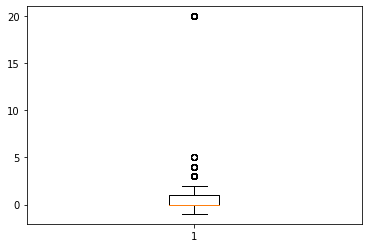

In [5]:
plt.boxplot(data['children'])

Анализ также можно провести путем использования метода `describe`.

In [6]:
data.describe()['children']

count    21525.000000
mean         0.538908
std          1.381587
min         -1.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         20.000000
Name: children, dtype: float64

Видно, что в данных присутствует набор заемщиков с количеством детей - 20. Скорее всего это тоже артефакт, и, возможно, вместо 20 имелось в виду 2. Также есть замщики с отрицательным количеством детей, что тоже должно являться артефактом.

В любом случае, заказчика интересует то, как влияет факт наличия детей, а не их количество на возврат кредита потенциальным заемщиком, поэтому данные артефакты мы также не будем трогать, но запомним, что они есть.

#### Столбец `days_employed`

Построим "ящик с усами" для столбца со стажем работы в днях (предварительно отбросив пропуски в значениях).

{'whiskers': [<matplotlib.lines.Line2D at 0x7f56d0b01b50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f56d0af7a50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f56d0b01b10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f56d0b13c50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f56d0b0dd50>],
 'means': []}

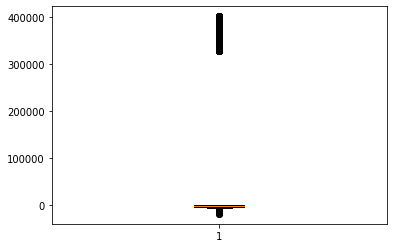

In [7]:
plt.boxplot(data['days_employed'].dropna())

Видно, что данные очень неоднородны. В таблице даже есть значения со стажем работы от 300000 до 400000 дней. Если перевести это в года, то это от 800 до 1000 проработанных лет. По всей видимости, эти артефакты были вызваны тем, что стаж был записан не в днях, а в часах, так как в таком случае стаж падает до приемлемых 34 - 46 лет.

Отсечем этот промежуток и построим график еще раз.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f56d0a79890>,
 'caps': [<matplotlib.lines.Line2D at 0x7f56d0a82f50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f56d0a79850>],
 'medians': [<matplotlib.lines.Line2D at 0x7f56d0a889d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f56d0a88ed0>],
 'means': []}

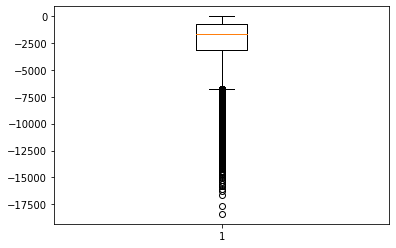

In [8]:
plt.boxplot(data[data['days_employed'] < 300000]['days_employed'])

Анализ также можно было провести методом `describe`.

In [9]:
data.describe()['days_employed']

count     19351.000000
mean      63046.497661
std      140827.311974
min      -18388.949901
25%       -2747.423625
50%       -1203.369529
75%        -291.095954
max      401755.400475
Name: days_employed, dtype: float64

Теперь видно, что распределение переместилось в отрицательную область.

Можно сказать, что все данные в столбце являются артефактными:
1. Значения стажа, записанного вместо дней в часах.
2. Значения стажа, которые по какой-то причине записаны отрицательными.

Заказчика не интересует зависимость предполагаемого возврата кредита от стажа работы, поэтому данные в этом столбце пока трогать мы не будем. Если это потребуется для последующей категоризации потенциальных заемщиков, то это необходимо иметь в виду.

#### Столбец `dob_years`

Построим "ящик с усами" для столбца со возрастом потенциального заемщика.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f56d09eba90>,
 'caps': [<matplotlib.lines.Line2D at 0x7f56d09f5d10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f56d09ebad0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f56d09fcbd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f56d0a14310>],
 'means': []}

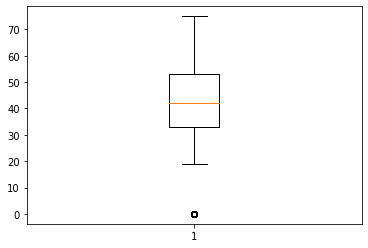

In [10]:
plt.boxplot(data['dob_years'])

Анализ также можно было провести методом `describe`.

In [11]:
data.describe()['dob_years']

count    21525.000000
mean        43.293380
std         12.574584
min          0.000000
25%         33.000000
50%         42.000000
75%         53.000000
max         75.000000
Name: dob_years, dtype: float64

В данном столбце видны артефакты в виде нулевого возраста. Возможно они возникли, когда потенциальный заемщик не указал свой возраст в заявке. 

С данным столбцом ситуация такая же, непосредственно заказчика возраст не интересует, но для дальнейшей работы нам эта информация может пригодиться.

#### Столбец `education`

Так как тип данных в данном случае текстовый, можно посмотреть список уникальных значений столбца.

In [12]:
data['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

Видно, что в данном случае наблюдаются неявные дубликаты, когда одни и те же данные записаны в разных стилях. Это также может нам пригодиться при дальнейшей категоризации данных.

#### Столбец `family_status`

Тоже посмотрим список уникальных значений столбца.

In [13]:
data['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

В данном столбце никаких неявных дубликатов не наблюдается.

#### Столбец `gender`

Посмотрим список уникальных значений столбца.

In [14]:
data['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

Видно, что есть один выбивающийся пол 'XNA'. Посмотрим строки с ним.

In [15]:
data[data['gender'] == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,-2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости


Видно, что в данном случае значение только одно, и его можно будет поменять либо на M, либо на F.

#### Столбец `income_type`

Изучим список уникальных значений столбца.

In [16]:
data['income_type'].unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

В данном столбце не наблюдается никаких артефактов.

#### Столбец `total_income`

Изучим столбец с ежемесячным доходом. 

{'whiskers': [<matplotlib.lines.Line2D at 0x7f56d095fe10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f56d0979750>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f56d0976050>],
 'medians': [<matplotlib.lines.Line2D at 0x7f56d0976d50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f56d09826d0>],
 'means': []}

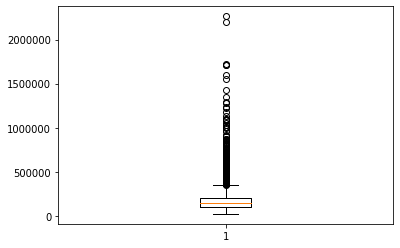

In [17]:
plt.boxplot(data['total_income'].dropna())

Анализ также можно было провести методом `describe`.

In [18]:
data.describe()['total_income']

count    1.935100e+04
mean     1.674223e+05
std      1.029716e+05
min      2.066726e+04
25%      1.030532e+05
50%      1.450179e+05
75%      2.034351e+05
max      2.265604e+06
Name: total_income, dtype: float64

Видно, что в данных присутствует небольшое количество людей с доходом 0,5 - 2,5 млн. рублей. В целом, эти цифры вполне реальны.

#### Столбец `purpose`

Изучим список уникальных значений этого столбца. 

In [19]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

На первый взгляд кажется, что целей получения кредитов много, но видно, что в их можно разделить на несколько категорий, образование/недвижимость/автомобиль/свадьба.

### Выводы


В каждой строке таблицы — основные данные о потенциальном заемщике, на основе которых заказчик должен решить, давать клиенту кредит или нет.

Мы прошлись по каждому столбцу и изучили разбросы данных в нем. Некоторые из данных могут повлиять на дальнейшую работу с данными, некоторые - нет. Однако, в любом случае необходимо держать в голове наличие тех или иных артефактов в столбцах.

## Предобработка данных

### Обработка пропусков

Сначала посмотрим, сколько в каждом столбце пропущенных значений.

In [20]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Видно, что в столбцах, соответствующих стажу в днях `days_employed` и ежемесячному доходу `total_income`, одинаковое количество пропусков - `2174`.

Проверим, одинаковые ли это пропуски. Для это посчитаем количество строк, в которых одновременно в двух этих столбцах нет значений.

In [21]:
data[data['days_employed'].isna() & data['total_income'].isna()].shape[0]

2174

Видно, что мы получили то же самое число - `2174`. Значит, на каждое отсутствующее значение в столбце `days_employed` пропущено значение в столбце `total_income`. 

Выдвинем предположение, что это может быть связано с типом занятости. Например, госслужащим нельзя говорить свой доход, а у студентов пока нет стажа. Посчитаем частоту каждого типа занятости в строках с пропущенными значениями. 

In [22]:
data[data['days_employed'].isna() & data['total_income'].isna()]['income_type'].value_counts()

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64

Сравним с частотой каждого типа занятости во всем датасете. 

In [23]:
data['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64

Видно, что значения для самых популярных типов занятости отличаются не сильно. Поэтому можно сделать вывод, что от типа занятости отсутствие значений не зависит.

Второй возможной причиной присутствия пропусков может быть то, что человек при заполнении заявки на кредит указывает, что у него отсутствует ежемесячный доход, и в системе ему сразу же присваивается отсутствия стажа (может быть также и наоборот). В этом есть логика, так как банк не будет давать кредит человеку без дохода, ведь его можно посчитать безработным.

Количество строк с пропущенными данными составляет около `10%`. В целом, эти данные можно удалить, но можно и оставить, так как данные об уровне дохода фигурируют только в одном из вопросов, на которые заказчику необходим ответ. Эти пропуски можно заполнить медианными значениями для категорий, в которые попадают те или иные заемщики.

Однако, для начала необходимо избавиться от следующих артефактов в данных:
1. Разный стиль написания образования.
2. Нулевой возраст.

Приведем значения в столбце с образованием к единому стилю.

Проверим список уникальных значений столбца.

In [24]:
data['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

Приведем значения к одному регистру.

In [25]:
data['education'] = data['education'].str.lower()

Проверим уникальные значения еще раз.

In [26]:
data['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

Теперь проверим, какое количество строк содержит нулевой возраст.

In [27]:
data[data['dob_years'] == 0].count()

children            101
days_employed        91
dob_years           101
education           101
education_id        101
family_status       101
family_status_id    101
gender              101
income_type         101
debt                101
total_income         91
purpose             101
dtype: int64

Всего 101 строка, то есть лишь 0,5 % всех данных. Но все же предлагается их заменить на медианные значения возраста в зависимости от типа занятости, образования и семейного статуса.

Для этого создадим сводную таблицу.

In [28]:
pivot_table_age = data.pivot_table(index=['education','family_status'], columns='income_type',
                                   values='dob_years', aggfunc='median')

Выведем таблицу на экран.

In [29]:
pivot_table_age

income_type                                безработный  в декрете  \
education           family_status                                   
высшее              Не женат / не замужем          NaN        NaN   
                    в разводе                      NaN        NaN   
                    вдовец / вдова                 NaN        NaN   
                    гражданский брак              45.0        NaN   
                    женат / замужем                NaN        NaN   
начальное           Не женат / не замужем          NaN        NaN   
                    в разводе                      NaN        NaN   
                    вдовец / вдова                 NaN        NaN   
                    гражданский брак               NaN        NaN   
                    женат / замужем                NaN        NaN   
неоконченное высшее Не женат / не замужем          NaN        NaN   
                    в разводе                      NaN        NaN   
                    вдовец / вдова                 NaN        NaN   
                    гражданский брак               NaN        NaN   
                    женат / замужем                NaN        NaN   
среднее             Не женат / не замужем          NaN        NaN   
                    в разводе                      NaN        NaN   
                    вдовец / вдова                 NaN        NaN   
                    гражданский брак               NaN        NaN   
                    женат / замужем               31.0       39.0   
ученая степень      Не женат / не замужем          NaN        NaN   
                    в разводе                      NaN        NaN   
                    женат / замужем                NaN        NaN   

income_type                                госслужащий  компаньон  пенсионер  \
education           family_status                                              
высшее              Не женат / не замужем         34.0       32.0       60.0   
                    в разводе                     36.0       42.0       59.0   
                    вдовец / вдова                53.5       53.0       60.0   
                    гражданский брак              40.0       36.0       59.0   
                    женат / замужем               37.0       38.0       59.0   
начальное           Не женат / не замужем         36.0       35.0       62.0   
                    в разводе                      NaN       43.5       63.0   
                    вдовец / вдова                 NaN        NaN       61.0   
                    гражданский брак              50.5       37.0       60.5   
                    женат / замужем               48.0       37.0       62.0   
неоконченное высшее Не женат / не замужем         27.0       26.0       64.0   
                    в разводе                      NaN       37.0       57.0   
                    вдовец / вдова                 NaN       52.0       59.0   
                    гражданский брак              24.0       29.5       58.0   
                    женат / замужем               34.0       34.0       59.0   
среднее             Не женат / не замужем         37.5       35.0       60.0   
                    в разводе                     44.0       44.0       60.0   
                    вдовец / вдова                52.0       53.0       61.0   
                    гражданский брак              42.0       39.5       59.0   
                    женат / замужем               42.0       41.0       59.0   
ученая степень      Не женат / не замужем          NaN        NaN        NaN   
                    в разводе                      NaN        NaN        NaN   
                    женат / замужем               36.0        NaN       65.5   

income_type                                предприниматель  сотрудник  студент  
education           family_status                                               
высшее              Не женат / не замужем              NaN       31.0     22.0  
                    в разводе 

Видно, что в данном случае много столбцов с отсутствующим значением. Чтобы от них избавиться, попробуем немного расширить категории. Для этого просто найдем медианы в зависимости от типа занятости.

In [30]:
grouped_table_income_type = data.groupby('income_type')['dob_years'].median()

In [31]:
grouped_table_income_type

income_type
безработный        38.0
в декрете          39.0
госслужащий        40.0
компаньон          39.0
пенсионер          60.0
предприниматель    42.5
сотрудник          39.0
студент            22.0
Name: dob_years, dtype: float64

In [32]:
def fill_zero_age(row):
    try:
        return grouped_table_income_type[row['income_type']]
    except:
        return 'Что-то не то, изучите данные'

Проверим работоспособность функции на одной из строк датасета, например, первой.

In [33]:
fill_zero_age(data.loc[0])

39.0

Похоже, что функция работает, теперь попробуем заменить нулевые значения.

In [34]:
for i in range(len(data['dob_years'])):
    if data.loc[i,'dob_years'] == 0:
        data.loc[i,'dob_years'] = grouped_table_income_type[data.loc[i, 'income_type']]

Проверим, есть ли в датасете нулевой возраст.

In [35]:
data[data['dob_years']==0].count()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

Теперь таких строк нет, можно продолжить.

Теперь необходимо заполнить пропуски в значениях ежемесячного дохода.
Для этого посчитаем медианные зарплаты для различных возрастных групп. Разделим группы на: до 30, от 30 до 65, от 60.

In [36]:
def age_group(age):
    if age <= 30:
        return 1
    if age <= 65:
        return 2
    return 3 

Теперь создадим отдельный столбец с возрастными группами.

In [37]:
data['age_group'] = data['dob_years'].apply(age_group)

Проверим наличие столбца в датасете.

In [38]:
data[['dob_years','age_group']].head(10)

,dob_years,age_group
0,42.0,2
1,36.0,2
2,33.0,2
3,32.0,2
4,53.0,2
5,27.0,1
6,43.0,2
7,50.0,2
8,35.0,2
9,41.0,2


Теперь создадим сводную таблицу.

In [39]:
pivot_table_income = data.pivot_table(index=['education', 'age_group'], columns='income_type', 
                                      values='total_income', aggfunc='median')

Выведем таблицу на экран.

In [40]:
pivot_table_income 

income_type                      безработный     в декрете    госслужащий  \
education           age_group                                               
высшее              1                    NaN           NaN  153859.652436   
                    2          202722.511368           NaN  176115.741875   
                    3                    NaN           NaN  199903.852498   
начальное           1                    NaN           NaN  191021.140719   
                    2                    NaN           NaN  105766.403301   
                    3                    NaN           NaN            NaN   
неоконченное высшее 1                    NaN           NaN  135252.995358   
                    2                    NaN           NaN  183009.578994   
                    3                    NaN           NaN            NaN   
среднее             1                    NaN           NaN  131892.785435   
                    2           59956.991984  53829.130729  136803.501484   
                    3                    NaN           NaN  158171.594823   
ученая степень      2                    NaN           NaN  111392.231107   
                    3                    NaN           NaN            NaN   

income_type                        компаньон      пенсионер  предприниматель  \
education           age_group                                                  
высшее              1          177744.178111  214963.301941    499163.144947   
                    2          212363.825056  149986.600709              NaN   
                    3          230056.048608  131561.334054              NaN   
начальное           1          132294.644611            NaN              NaN   
                    2          163403.016785  108567.549331              NaN   
                    3                    NaN   89777.620811              NaN   
неоконченное высшее 1          159817.845686            NaN              NaN   
                    2          196481.989512  120136.896353              NaN   
                    3                    NaN  107969.834964              NaN   
среднее             1          149280.652841   72621.149221              NaN   
                    2          161998.828912  117513.425518              NaN   
                    3          151623.041568  105419.161980              NaN   
ученая степень      2                    NaN  255425.196556              NaN   
                    3                    NaN   98752.495442              NaN   

income_type                        сотрудник       студент  
education           age_group                               
высшее              1          152363.984148  98201.625314  
                    2          169625.952239           NaN  
                    3          157108.854344           NaN  
начальное           1          147084.634936           NaN  
                    2          124397.467932           NaN  
                    3          179369.498314           NaN  
неоконченное высшее 1          137269.057934           NaN  
                    2          168973.256345           NaN  
                    3          211207.224592           NaN  
среднее             1          126712.253721           NaN  
                    2          138329.936872           NaN  
                    3          152440.149996           NaN  
ученая степень      2          198570.757322           NaN  
                    3                    NaN           NaN

Теперь создадим соответствующую функцию.

In [41]:
def fill_nan_income(row):
    try:
        return pivot_table_income[row['income_type']][row['education']][row['age_group']]
    except:
        return 'Что-то не то, изучите данные'

Проверим работоспособность функции на одной из строк датасета, например, первой.

In [42]:
fill_nan_income(data.loc[0])

169625.95223945146

Надо иметь в виду, что для некоторых значений в сводной таблице также отсутствуют значения. Поэтому проверим количество пропущенных значений в столбце до замены.

In [43]:
data['total_income'].isna().sum()

2174

Итак, в столбце с зарплатой 2174 пропущенных данных.

Заменим все пропуски на медианные значения для групп.

In [44]:
data.loc[data['total_income'].isna(),'total_income'] = data.apply(fill_nan_income, axis=1)

Опять проверим количество пропущенных значений в столбце.

In [45]:
data['total_income'].isna().sum()

1

Итак, видно, что осталось одно пропущенное значение. Посмотрим, что это за значение.

In [46]:
data[data['total_income'].isna()]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
5936,0,NaN,58.0,высшее,0,женат / замужем,0,M,предприниматель,0,NaN,покупка жилой недвижимости,2


Пропущенное значение соответствует типу занятости - предприниматель. Посмотрим на строки других предпринимателей.

In [47]:
data[data['income_type']=='предприниматель']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
5936,0,NaN,58.0,высшее,0,женат / замужем,0,M,предприниматель,0,NaN,покупка жилой недвижимости,2
18697,0,-520.848083,27.0,высшее,0,гражданский брак,1,F,предприниматель,0,499163.144947,на проведение свадьбы,1


Видно, что предпринимателя на весь датасет всего два. Предлагается приравнять зарплаты предпринимателей.

In [48]:
data.loc[5936,'total_income'] = data.loc[18697,'total_income']

Проверим количество пропущенных значений еще раз.

In [49]:
data['total_income'].isna().sum()

0

Итак, пропущенных значений в столбце нет, можно продолжать.

**Вывод**

В данных присутствовали пропуски одновременно в двух столбцах, соответствующих общему стажу в днях и ежемесячному доходу. Также присутствовали нулевые значения в столбце с возрастом заемщика.

Были проведены следующие операции:

1. В столбце с возрастом заемщика нулевые значения были заменены на медианные значения возраста для групп по образованию, семейному статусу и типу занятости.
2. В столбце с ежемесячным доходом пропуски были заменены на медианные значения, характерные для групп по образованию, типу занятости и возрастной группе. После этого в столбце все еще осталось пропущенное значение для предпринимателя, которое было заменено на зарплату другого предпринимателя, так как их всего два в датасете.

Возможной причиной появления пропусков является особенность системы, используемой при подаче заявки на кредит.

### Замена типа данных

Проверим информацию о таблицы еще раз.

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null float64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
age_group           21525 non-null int64
dtypes: float64(3), int64(5), object(5)
memory usage: 2.1+ MB


Заменим тип данных в столбце `total_income` на целочисленный, так как доход в целом лучше округлить до целого значения. Для этого будем использовать функцию `astype`.

In [51]:
data['total_income'] = data['total_income'].astype('int')

Проверим информацию о столбцах еще раз.

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null float64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null int64
purpose             21525 non-null object
age_group           21525 non-null int64
dtypes: float64(2), int64(6), object(5)
memory usage: 2.1+ MB


Видно, что тип данных поменялся.

**Вывод**

На данном этапе была необходима замена вещественного типа данных в столбце ежемесячного дохода на целочисленный.

### Обработка дубликатов

Проверим, есть ли в данных явные дубликаты.

In [53]:
data.duplicated().sum()

71

Похоже, в датасете присутствует 71 дубликата.

При этом надо понимать, что наличие дубликатов не означает одинаковых заемщиков. Как минимум, мы заменяли отсутствующие значения возраста и зарплат на медианные значения для групп. Это тоже могло привести к появлению дубликатов. Но все же, давайте их удалим.

In [54]:
data = data.drop_duplicates().reset_index(drop=True)

Посчитаем количество дубликатов еще раз.

In [55]:
data.duplicated().sum()

0

Видно, что теперь в столбце нет дубликатов. 

**Вывод**

В таблице присутствовало 71 явных дубликата, которые были удалены.

### Лемматизация

Для того, чтобы в дальнейшем категоризировать цели получения кредитов, необходимо провести их лемматизацию.

Для этого сначала импортируем библиотеку `pymystem3`.

In [56]:
from pymystem3 import Mystem
m = Mystem()

Добавим столбец с леммами для каждой цели получения кредита.

Сначала напишем функцию, которая возвращает лемматизирование значение.

In [57]:
def lemmatize_purpose(row):
    try:
        return m.lemmatize(row['purpose'])
    except:
        return 'Что-то не то, изучите данные'

Проверим работу программы, например, на первой строке данных.

In [58]:
lemmatize_purpose(data.loc[0])

['покупка', ' ', 'жилье', '\n']

Видно, что лемматизация работает.

На следующем этапе лемматизируем все строки датасета.

In [59]:
data['lemmas'] = data.apply(lemmatize_purpose,axis=1)

Посмотрим на датасет, чтобы проверить столбец с леммами.

In [60]:
data['lemmas'].head(10)

0                      [покупка,  , жилье, \n]
1            [приобретение,  , автомобиль, \n]
2                      [покупка,  , жилье, \n]
3         [дополнительный,  , образование, \n]
4                    [сыграть,  , свадьба, \n]
5                      [покупка,  , жилье, \n]
6               [операция,  , с,  , жилье, \n]
7                            [образование, \n]
8          [на,  , проведение,  , свадьба, \n]
9    [покупка,  , жилье,  , для,  , семья, \n]
Name: lemmas, dtype: object

На следующем этапе будем использовать полученный столбец для категоризации целей выдачи кредита.

**Вывод**

На данном этапе был лемматизирован столбец с целью кредита. Далее на основе полученных лемм будет происходить категоризация заемщиков.

### Категоризация данных

Итак, напомним, на какие вопросы необхдим ответ заказчику:
1. Есть ли зависимость между наличием детей и возвратом кредита в срок?
2. Есть ли зависимость между семейным положением и возвратом кредита в срок?
3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
4. Как разные цели кредита влияют на его возврат в срок?

Соответственно, предлагается категоризировать заемщиков следующим образом:
1. Бездетный/есть дети.
2. По семейному положению. 
3. По уровню дохода, например по средней заработной плате по России.
4. По целям выдачи кредита.

#### Категоризация по детям

Создадим соответствующую функцию.

In [61]:
def children_group(row):
    if row['children'] != 0:
        return 'есть дети'
    return 'бездетный'

Применим функцию к датасету, создав новый столбец.

In [62]:
data['children_group'] = data.apply(children_group,axis=1)

Проверим полученный столбец.

In [63]:
data['children_group'].head(10)

0    есть дети
1    есть дети
2    бездетный
3    есть дети
4    бездетный
5    бездетный
6    бездетный
7    бездетный
8    есть дети
9    бездетный
Name: children_group, dtype: object

Функция работает, переходим к следующей категории.

#### Категоризация по семейному положению

В самом начале проекта мы проверяли список уникальных значений столбца с семейным положениям. Проверим еще раз.

In [64]:
data['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

Видно, что в данному случае категоризацию проводить не обязательно, так как заемщики итак разделены по данной категории.

#### Категоризация по уровню дохода

Для данной категоризации будем использовать среднюю зарплату в России за 2020 год [1].

1. https://vc.ru/finance/128505-samaya-rasprostranennaya-zarplata-v-rossii-i-naskolko-ona-nizhe-sredney-pochemu-u-70-lyudey-zarplata-nizhe-srednego-urovnya

In [65]:
avg_income = 50000

Введем следующие категории:
- Менее средней зарплаты - "средний класс".
- От средней зарплаты до двух средних зарплат - "верхний средний класс".
- От двух средних зарплат до четырех средних зарплат - "состоятельные".
- Больше четырех средних зарплат - "богатые".

Напишем соответствующую функцию.

In [66]:
def income_group(row):
    if row['total_income'] <= avg_income:
        return 'средний класс'
    if row['total_income'] <= 2*avg_income:
        return 'верхний средний класс'
    if row['total_income'] <= 4*avg_income:
        return 'состоятельные'
    return 'богатые'

Проведем соответствующую характеризацию.

In [67]:
data['income_group'] = data.apply(income_group,axis=1)

Проверим соответствующий столбец.

In [68]:
data[['total_income','income_group']].head(10)

,total_income,income_group
0,253875,богатые
1,112080,состоятельные
2,145885,состоятельные
3,267628,богатые
4,158616,состоятельные
5,255763,богатые
6,240525,богатые
7,135823,состоятельные
8,95856,верхний средний класс
9,144425,состоятельные


Категоризация по данному признаку прошла, пойдем дальше.

#### Категоризация по цели выдачи кредита

Посмотрим еще раз на список уникальных значений столбца с целью выдачи кредита.

In [69]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Видно, что все цели можно разделить на следующие категории:
1. Образование
2. Свадьба
3. Автомобиль
4. Недвижимость

Напишем соответствующую функцию.

In [70]:
def purpose_group(row):
    try:
        for word in row['lemmas']:
            if word == 'образование':
                return 'образование'
            if word == 'свадьба':
                return 'свадьба'
            if word == 'автомобиль':
                return 'автомобиль'
            if word == 'жилье' or word == 'недвижимость':
                return 'недвижимость'
    except:
        print('Что-то пошло не так, проверь данные')

Добавим соответствующий столбец.

In [71]:
data['purpose_group'] = data.apply(purpose_group,axis=1)

Проверим соответствующие столбцы.

In [72]:
data[['purpose','purpose_group']].head(20)

,purpose,purpose_group
0,покупка жилья,недвижимость
1,приобретение автомобиля,автомобиль
2,покупка жилья,недвижимость
3,дополнительное образование,образование
4,сыграть свадьбу,свадьба
5,покупка жилья,недвижимость
6,операции с жильем,недвижимость
7,образование,образование
8,на проведение свадьбы,свадьба
9,покупка жилья для семьи,недвижимость


Проверим список уникальных значений столбца.

In [73]:
data['purpose_group'].unique()

array(['недвижимость', 'автомобиль', 'образование', 'свадьба'],
      dtype=object)

Видно, что удалось разделить все цели получения кредита на четыре категории без ошибочных значений.

**Вывод**

На данном этапе была проведена категоризация заемщиков по четырем категориям: по наличию детей, по семейному положению, по уровню дохода и цели получения кредита.

Полученные категории будут использоваться на последнем этапе для ответа на вопросы, интересующие заказчика.

## Отвечаем на вопросы заказчика

### Есть ли зависимость между наличием детей и возвратом кредита в срок?

Посчитаем колиество должников среди людей с детьми и без.

Также добавим столбец с долей должников от общего количества заемщиков.

Выведем полученную таблицу на экран, отсортировав долю по возрастанию количества должников.

In [74]:
children_debt = data.groupby('children_group')['debt'].agg(['sum','count'])
children_debt['share'] = children_debt['sum']/children_debt['count']*100
children_debt.sort_values('share')

,sum,count,share
children_group,,,
бездетный,1063,14091,7.543822
есть дети,678,7363,9.208203


**Вывод**

Видно, что доля должников среди бездетных заемщиков составляет 7.5 %. Доля должников среди заемщиков с детьми при этом составляет 9.2 %, то есть на 23 % больше соответствующего значения для бездетных заемщиков.

Такой результат можно объяснить тем, что у заемщиков с детьми есть дополнительные расходы непосредственно на детей, что может приводить к проблемам с нахождением свободных средств на выплаты по кредитам.

### Есть ли зависимость между семейным положением и возвратом кредита в срок?

Посчитаем количество должников среди людей с различным семейным положением.

Также добавим столбец с долей должников от общего количества заемщиков.

Выведем полученную таблицу на экран, отсортировав долю по возрастанию количества должников.

In [75]:
family_debt = data.groupby('family_status')['debt'].agg(['sum','count'])
family_debt['share'] = family_debt['sum']/family_debt['count']*100
family_debt.sort_values('share')

,sum,count,share
family_status,,,
вдовец / вдова,63,959,6.569343
в разводе,85,1195,7.112971
женат / замужем,931,12339,7.545182
гражданский брак,388,4151,9.347145
Не женат / не замужем,274,2810,9.750890


**Вывод**

По полученным данным видно, что:
- Должников по кредитным выплатам среди заемщики, которые относятся к категории не женатых/не замужних и живущих в гражданском браке примерно одинаково, 9.8 и 9.3 %, соответственно.

- Количество должников среди заемщиков в разводе и женатые/замужних 7.1 и 7.5 %, соответственно.

- Уровень невозвратов среди вдовцов/вдов составляет 6.5 %.

Люди, которые еще не вступали в официальный брак возвращают кредиты меньше всех. Это может быть связано с их меньшим уровнем ответственности. При этом видно, что должников среди люди в браке и разведенных меньше. Возможно, брак делает людей более ответственными... 

Вдовы и вдовцы при этом возвращают кредиты лучше всех.

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Посчитаем количество должников среди людей с различным уровнем дохода.

Также добавим столбец с долей должников от общего количества заемщиков.

Выведем полученную таблицу на экран, отсортировав долю по возрастанию количества должников.

In [76]:
income_debt = data.groupby('income_group')['debt'].agg(['sum','count'])
income_debt['share'] = income_debt['sum']/income_debt['count']*100
income_debt.sort_values('share')

,sum,count,share
income_group,,,
средний класс,23,372,6.182796
богатые,365,5211,7.004414
верхний средний класс,331,4092,8.088954
состоятельные,1022,11779,8.676458


**Вывод**

По полученным данным видно, что люди с минимальным доходом среди остальных - "средний класс" возвращает кредиты лучше всех. Возможной причиной является то, что они наиболее ответственны среди остальных, так они понимают, что в случае просрочки, им придется платить штрафные пени, что может дополнительно ударить по их бюджету.

Следующая категория, "верхний средний класс" возвращает кредиты хуже. Это может быть связано с тем, что при увеличении своего дохода некоторые люди могут брать больше кредитов, плохо рассчитывая свою кредитную нагрузку, что и приводит к меньшей доле своевременных платежей по кредитам в таком классе.

"Богатые", в свою очередь, возвращают кредиты чаще, чем "верхний средний класс", но хуже, чем "средний класс".

"Состоятельные" же люди возвращают кредиты хуже всех. Это может показаться странным, но, возможно, это связано с тем, что они берут кредиты на большие суммы, что с большей вероятностью может повлечь за собой просрочки платежей, если в их жизни произойдут какие-то изменения и они потеряют свою работу.

### Как разные цели кредита влияют на его возврат в срок?

Посчитаем количество должников среди людей с различными целями кредита.

Также добавим столбец с долей должников от общего количества заемщиков.

Выведем полученную таблицу на экран, отсортировав долю по возрастанию количества должников.

In [77]:
purpose_debt = data.groupby('purpose_group')['debt'].agg(['sum','count'])
purpose_debt['share'] = purpose_debt['sum']/purpose_debt['count']*100
purpose_debt.sort_values('share')

,sum,count,share
purpose_group,,,
недвижимость,782,10811,7.233373
свадьба,186,2324,8.003442
образование,370,4013,9.220035
автомобиль,403,4306,9.359034


**Вывод**

В данном случае видно, что процент должников с целью кредита "недвижимость" меньше всего. Возможно это связано с тем, что люди не очень хотят терять свою недвижимость в случае невыплаты кредита банком, так как обычно недвижимость принадлежит банку до полной выплаты кредита.

Процент должников среди цели кредита "образование" и "автомобиль" больше всего.

## Общий вывод

В данном проекте от заказчика был получен датасет с данными о потенциальных заемщиках.

Для работы с данными предварительно были проведены следующие этапы работы с датасетом:
1. Очищены пропуски в данных и заменены на медианные значения для групп, к котором относились эти заемщики.
2. Удалены дубликаты.
3. Проведена категоризация данных для упрощения ответов на вопросы заказчика.

На последнем этапе были даны ответы на вопросы заказчика о том, как разные категории заемщиков возвращают кредиты.

В дальнейшем предполагается, что заказчик будет использовать данную информацию для одобрения кредитов для тех или иных категорий потенциальных заемщиков.